# Dual-Dataset Approach - Ensemble Learning / Meta-Learning

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib  # For loading/saving models and data
from pathlib import Path  # For robust file path handling
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression  # Base models & Meta-model
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc, f1_score, precision_score, recall_score

In [2]:
# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)  # Default figure size for plots

In [3]:
# Define a random state for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

Define Evaluation Function

In [4]:
# --- 1. Define Evaluation Function ---
# Copying the evaluation function from previous phases for consistency.
# In a real project, this would ideally be in a 'scripts/' folder and imported.
def evaluate_model(model, X_test, y_test, model_name, strategy_name, results_list):
    """
    Evaluates a trained classification model and prints key metrics,
    plots the Precision-Recall curve, and stores results.
    
    Args:
        model: Trained scikit-learn compatible classifier.
        X_test: Test features.
        y_test: True test labels.
        model_name (str): Name of the model.
        strategy_name (str): Description of the evaluation strategy.
        results_list (list): List to append model results.
    """
    print(f"--- Evaluating {model_name} ({strategy_name}) ---")
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))  # Added zero_division=0 for cleaner output
    
    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(cm)
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.title(f'Confusion Matrix: {model_name} ({strategy_name})')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()
    
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"\nROC AUC Score: {roc_auc:.4f}")
    
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)
    print(f"Precision-Recall AUC (AUPRC): {pr_auc:.4f}")
    
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='darkorange', lw=2,
             label=f'PR curve (area = {pr_auc:.2f})')
    plt.xlabel('Recall (Fraud)')
    plt.ylabel('Precision (Fraud)')
    plt.title(f'Precision-Recall Curve: {model_name} ({strategy_name})')
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    metrics = {
        'Model': model_name,
        'Strategy': strategy_name,
        'Accuracy': (cm[0,0] + cm[1,1]) / np.sum(cm),
        'Precision (Fraud)': precision_score(y_test, y_pred, pos_label=1, zero_division=0),
        'Recall (Fraud)': recall_score(y_test, y_pred, pos_label=1, zero_division=0),
        'F1-Score (Fraud)': f1_score(y_test, y_pred, pos_label=1, zero_division=0),
        'ROC AUC': roc_auc,
        'AUPRC': pr_auc,
        'True Positives (TP)': cm[1,1],
        'False Positives (FP)': cm[0,1],
        'False Negatives (FN)': cm[1,0]
    }
    
    results_list.append(metrics)
    print("\n" + "="*80 + "\n")

# Initialize a list to store results for Phase 5
ensemble_results = []

## Load Preprocessed Data & Base Models

In [5]:
# --- Step 1: Load Preprocessed Data & Base Models ---
print("--- Phase 5, Step 1: Loading Preprocessed Data & Base Models ---")

# Define data and model directories using Path for robust file handling
data_dir = Path('../data')
model_dir = Path('../data')

--- Phase 5, Step 1: Loading Preprocessed Data & Base Models ---


Load 2013 Preprocessed Data (from Phase 3 setup, commom features scaled by 2013 scalar)

In [6]:
# 1.1 Load 2013 Preprocessed Data (from Phase 3 setup, common features scaled by 2013 scaler)
print("\n--- 1.1 Loading 2013 Preprocessed Data ---")
try:
    loaded_phase3_data = joblib.load(data_dir / 'preprocessed_data_phase3.pkl')
    X_train_2013_scaled = loaded_phase3_data['X_train_2013_scaled']
    X_test_2013_scaled = loaded_phase3_data['X_test_2013_scaled']
    y_train_2013 = loaded_phase3_data['y_train_2013']
    y_test_2013 = loaded_phase3_data['y_test_2013']
    X_2023_scaled_for_drift_test = loaded_phase3_data['X_2023_scaled_for_drift_test']  # 2023 data scaled by 2013 scaler
    
    # Also need the original raw common features for 2013 to apply 2023 scaler in next step
    df_2013_raw = pd.read_csv(data_dir / 'creditcard.csv')
    common_features = [f'V{i}' for i in range(1, 29)] + ['Amount']
    X_2013_common_raw_full = df_2013_raw[common_features]
    
    print("2013 preprocessed data loaded successfully.")
    print(f"X_train_2013_scaled shape: {X_train_2013_scaled.shape}")
    print(f"X_test_2013_scaled shape: {X_test_2013_scaled.shape}")
    print(f"y_train_2013 shape: {y_train_2013.shape}")
    print(f"y_test_2013 shape: {y_test_2013.shape}")
    print(f"X_2023_scaled_for_drift_test shape: {X_2023_scaled_for_drift_test.shape}")
    print(f"2013 Class Distribution (y_test_2013):")
    print(pd.Series(y_test_2013).value_counts(normalize=True))
except FileNotFoundError:
    print(f"Error: 2013 preprocessed data files not found. Ensure '{data_dir / 'preprocessed_data_phase3.pkl'}' exists.")
    exit()
except KeyError as e:
    print(f"Error: Missing key in preprocessed_data_phase3.pkl: {e}")
    exit()
except Exception as e:
    print(f"Unexpected error while loading 2013 data: {e}")
    exit()


--- 1.1 Loading 2013 Preprocessed Data ---
2013 preprocessed data loaded successfully.
X_train_2013_scaled shape: (227845, 29)
X_test_2013_scaled shape: (56962, 29)
y_train_2013 shape: (227845,)
y_test_2013 shape: (56962,)
X_2023_scaled_for_drift_test shape: (568630, 29)
2013 Class Distribution (y_test_2013):
Class
0    0.99828
1    0.00172
Name: proportion, dtype: float64


Load 2023 Preprocessed Data (from Phase 2 setup, commom features scaled by 2023 scalar)

In [7]:
# 1.2 Load 2023 Preprocessed Data (from Phase 2 setup, common features scaled by 2023 scaler)
print("\n--- 1.2 Loading 2023 Preprocessed Data ---")
try:
    loaded_phase2_data = joblib.load(data_dir / 'preprocessed_data_2023.pkl')
    
    # Check if loaded_phase2_data is a tuple/list and access by indices
    if isinstance(loaded_phase2_data, (list, tuple)):
        print("Note: preprocessed_data_2023.pkl is a tuple/list. Accessing by indices.")
        X_train_2023_orig_scaled = loaded_phase2_data[0]
        X_test_2023_orig_scaled = loaded_phase2_data[1]
        y_train_2023_orig = loaded_phase2_data[2]
        y_test_2023_orig = loaded_phase2_data[3]
    else:
        print("Note: preprocessed_data_2023.pkl is a dictionary. Accessing by keys.")
        X_train_2023_orig_scaled = loaded_phase2_data['X_train_2023_orig_scaled']
        X_test_2023_orig_scaled = loaded_phase2_data['X_test_2023_orig_scaled']
        y_train_2023_orig = loaded_phase2_data['y_train_2023_orig']
        y_test_2023_orig = loaded_phase2_data['y_test_2023_orig']
    
    # Load 2023 scaler for transforming 2013 data for 2023 model
    try:
        scaler_2023 = joblib.load(data_dir / 'scaler_2023.pkl')  # Prefer Phase 2-specific scaler if available
        print("2023 scaler (scaler_2023.pkl) loaded successfully.")
    except FileNotFoundError:
        print("Warning: scaler_2023.pkl not found. Using scaler_combined.pkl as fallback.")
        try:
            scaler_2023 = joblib.load(data_dir / 'scaler_combined.pkl')  # Fallback to combined scaler
            print("Fallback scaler (scaler_combined.pkl) loaded successfully.")
        except FileNotFoundError:
            print(f"Error: Neither scaler_2023.pkl nor scaler_combined.pkl found in {data_dir}. Please provide a valid scaler file.")
            exit()
    
    print("2023 preprocessed data loaded successfully.")
    print(f"X_train_2023_orig_scaled shape: {X_train_2023_orig_scaled.shape}")
    print(f"X_test_2023_orig_scaled shape: {X_test_2023_orig_scaled.shape}")
    print(f"y_train_2023_orig shape: {y_train_2023_orig.shape}")
    print(f"y_test_2023_orig shape: {y_test_2023_orig.shape}")
    print(f"2023 Class Distribution (y_test_2023_orig):")
    print(pd.Series(y_test_2023_orig).value_counts(normalize=True))
except FileNotFoundError:
    print(f"Error: 2023 preprocessed data files not found. Ensure '{data_dir / 'preprocessed_data_2023.pkl'}' exists.")
    exit()
except IndexError as e:
    print(f"Error: Invalid index access in preprocessed_data_2023.pkl. Expected a tuple with at least 4 elements: {e}")
    exit()
except Exception as e:
    print(f"Unexpected error while loading 2023 data: {e}")
    exit()


--- 1.2 Loading 2023 Preprocessed Data ---
Note: preprocessed_data_2023.pkl is a tuple/list. Accessing by indices.
Fallback scaler (scaler_combined.pkl) loaded successfully.
2023 preprocessed data loaded successfully.
X_train_2023_orig_scaled shape: (454904, 29)
X_test_2023_orig_scaled shape: (113726, 29)
y_train_2023_orig shape: (454904,)
y_test_2023_orig shape: (113726,)
2023 Class Distribution (y_test_2023_orig):
Class
1    0.5
0    0.5
Name: proportion, dtype: float64


Load 2013-Trained Base Model (XGBoost)

In [8]:
# 1.3 Load 2013-Trained Base Model (XGBoost)
print("\n--- 1.3 Loading 2013-Trained Base Model ---")
try:
    xgb_model_2013 = joblib.load(model_dir / 'xgb_model_2013.pkl')
    print("2013-trained XGBoost model loaded successfully:")
    print(xgb_model_2013)
except FileNotFoundError:
    print(f"Error: 2013 XGBoost model not found. Ensure '{model_dir / 'xgb_model_2013.pkl'}' exists.")
    exit()
except Exception as e:
    print(f"Unexpected error while loading 2013 XGBoost model: {e}")
    exit()


--- 1.3 Loading 2013-Trained Base Model ---
2013-trained XGBoost model loaded successfully:
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=-1,
              num_parallel_tree=None, ...)


Load 2023-Trainedd Base Model (Random Forest)

In [9]:
# 1.4 Load 2023-Trained Base Model (Random Forest)
print("\n--- 1.4 Loading 2023-Trained Base Model ---")
try:
    rf_2023_model = joblib.load(model_dir / 'best_model_2023_random_forest_balanced_data.pkl')
    print("2023-trained Random Forest model loaded successfully:")
    print(rf_2023_model)
except FileNotFoundError:
    print(f"Error: 2023 Random Forest model not found. Ensure '{model_dir / 'best_model_2023_random_forest_balanced_data.pkl'}' exists.")
    exit()
except Exception as e:
    print(f"Unexpected error while loading 2023 Random Forest model: {e}")
    exit()


--- 1.4 Loading 2023-Trained Base Model ---
2023-trained Random Forest model loaded successfully:
RandomForestClassifier(n_jobs=-1, random_state=42)


Print Confirmation

In [10]:
# 1.5 Print Confirmation
print("\nStep 1 Completed: All preprocessed data and base models loaded successfully.")
print("\n" + "="*80 + "\n")


Step 1 Completed: All preprocessed data and base models loaded successfully.




In [11]:
# --- Reload data/models if kernel restarted from previous steps ---
# This block ensures all necessary variables are available if the notebook was reset.
print("--- Reloading Data and Models (if kernel restarted) ---")
try:
    # Reload 2013 preprocessed data (including X_2023_scaled_for_drift_test)
    loaded_phase3_data = joblib.load(data_dir / 'preprocessed_data_phase3.pkl')
    X_train_2013_scaled = loaded_phase3_data['X_train_2013_scaled']
    X_test_2013_scaled = loaded_phase3_data['X_test_2013_scaled']
    y_train_2013 = loaded_phase3_data['y_train_2013']
    y_test_2013 = loaded_phase3_data['y_test_2013']
    X_2023_scaled_for_drift_test = loaded_phase3_data['X_2023_scaled_for_drift_test']  # 2023 data scaled by 2013 scaler
    
    # Reload 2023 preprocessed data (original scaling)
    loaded_phase2_data = joblib.load(data_dir / 'preprocessed_data_2023.pkl')
    X_train_2023_orig_scaled = loaded_phase2_data[0]
    X_test_2023_orig_scaled = loaded_phase2_data[1]
    y_train_2023_orig = loaded_phase2_data[2]
    y_test_2023_orig = loaded_phase2_data[3]
    
    # Reload 2013 raw common features (needed for 2023 scaler transformation)
    df_2013_raw = pd.read_csv(data_dir / 'creditcard.csv')
    common_features = [f'V{i}' for i in range(1, 29)] + ['Amount']
    X_2013_common_raw_full = df_2013_raw[common_features]
    
    # Reload scalers
    # Try loading scaler_2023.pkl first, then fallback to scaler_combined.pkl
    try:
        scaler_2023 = joblib.load(data_dir / 'scaler_2023.pkl')
        print("2023 scaler (scaler_2023.pkl) reloaded.")
    except FileNotFoundError:
        scaler_2023 = joblib.load(data_dir / 'scaler_combined.pkl')  # Fallback
        print("2023 scaler (scaler_combined.pkl) reloaded as fallback.")
    
    # Reload base models
    xgb_model_2013 = joblib.load(data_dir / 'xgb_model_2013.pkl')
    rf_2023_model = joblib.load(data_dir / 'best_model_2023_random_forest_balanced_data.pkl')
    
    print("All data and models reloaded successfully.")
except Exception as e:
    print(f"Error reloading data/models: {e}. Please ensure all previous phases were run correctly and files are saved.")
    exit()
print("\n" + "="*80 + "\n")

--- Reloading Data and Models (if kernel restarted) ---
2023 scaler (scaler_combined.pkl) reloaded as fallback.
All data and models reloaded successfully.




## Generate Predictions for Meta-Model (Blending Approach)

In [12]:
# --- Step 2: Generate Predictions for Meta-Model (Blending Approach) ---
print("--- Phase 5, Step 2: Generating Predictions for Meta-Model ---")


--- Phase 5, Step 2: Generating Predictions for Meta-Model ---


Prepare Combined Test Set for Ensemble Evaluation

In [13]:
# 2.1 Prepare Combined Test Set for Ensemble Evaluation
print("\n--- 2.1 Preparing Combined Test Set for Ensemble Evaluation ---")
# This will be the actual test set on which the final ensemble model is evaluated.
# It uses the native scaling from each dataset's processing pipeline.
try:
    # Ensure inputs are DataFrames for pd.concat
    X_test_2013_scaled_df = X_test_2013_scaled if isinstance(X_test_2013_scaled, pd.DataFrame) else pd.DataFrame(X_test_2013_scaled, columns=common_features)
    X_test_2023_orig_scaled_df = X_test_2023_orig_scaled if isinstance(X_test_2023_orig_scaled, pd.DataFrame) else pd.DataFrame(X_test_2023_orig_scaled, columns=common_features)
    
    # Concatenate test features from 2013 and 2023 datasets
    X_test_combined_ensemble = pd.concat([X_test_2013_scaled_df, X_test_2023_orig_scaled_df], ignore_index=True)
    # Concatenate test labels
    y_test_combined_ensemble = pd.concat([pd.Series(y_test_2013), pd.Series(y_test_2023_orig)], ignore_index=True)
    
    print(f"Combined ensemble test features shape: {X_test_combined_ensemble.shape}")
    print(f"Combined ensemble test target shape: {y_test_combined_ensemble.shape}")
    print(f"Combined ensemble test class distribution:\n{y_test_combined_ensemble.value_counts(normalize=True)}")
    print("\nInsight: The combined test set is prepared for final ensemble evaluation, preserving the relative class distribution from the original combined dataset.")
except Exception as e:
    print(f"Error while creating combined test set: {e}")
    exit()
print("\n" + "="*80 + "\n")




--- 2.1 Preparing Combined Test Set for Ensemble Evaluation ---
Combined ensemble test features shape: (170688, 29)
Combined ensemble test target shape: (170688,)
Combined ensemble test class distribution:
Class
0    0.666286
1    0.333714
Name: proportion, dtype: float64

Insight: The combined test set is prepared for final ensemble evaluation, preserving the relative class distribution from the original combined dataset.




Generate Predictions from Base Model 1 (2013-trained XGBoost)

In [14]:
# 2.2 Generate Predictions from Base Model 1 (2013-trained XGBoost)
print("--- 2.2 Generating Predictions from 2013-trained XGBoost Model ---")
# Model 1 (xgb_model_2013) was trained on 2013 data scaled by 2013 scaler.
# So, it expects data to be scaled by the 2013 scaler.
try:
    # Predict on 2013 Test Data (already scaled by 2013 scaler)
    xgb_proba_on_2013_test = xgb_model_2013.predict_proba(X_test_2013_scaled)[:, 1]
    print(f"XGBoost (2013) predictions on 2013 test data generated. Shape: {xgb_proba_on_2013_test.shape}")
    
    # Predict on 2023 Test Data (scaled by 2013 scaler, from Phase 3's drift test setup)
    # Re-slice X_2023_scaled_for_drift_test to get just the test set part
    X_test_2023_scaled_by_2013_scaler_for_ensemble = X_2023_scaled_for_drift_test.loc[y_test_2023_orig.index]
    xgb_proba_on_2023_test = xgb_model_2013.predict_proba(X_test_2023_scaled_by_2013_scaler_for_ensemble)[:, 1]
    print(f"XGBoost (2013) predictions on 2023 test data (scaled by 2013 scaler) generated. Shape: {xgb_proba_on_2023_test.shape}")
    print("\nInsight: XGBoost (2013) has made predictions on both 2013 and 2023 data using its native scaling, as expected for a drift-aware ensemble.")
except Exception as e:
    print(f"Error while generating XGBoost predictions: {e}")
    exit()
print("\n" + "="*80 + "\n")



--- 2.2 Generating Predictions from 2013-trained XGBoost Model ---
XGBoost (2013) predictions on 2013 test data generated. Shape: (56962,)
XGBoost (2013) predictions on 2023 test data (scaled by 2013 scaler) generated. Shape: (113726,)

Insight: XGBoost (2013) has made predictions on both 2013 and 2023 data using its native scaling, as expected for a drift-aware ensemble.




Generate Predictions from Base Model 2 (2023-trained Random Forest)

In [15]:
# 2.3 Generate Predictions from Base Model 2 (2023-trained Random Forest)
print("--- 2.3 Generating Predictions from 2023-trained Random Forest Model ---")
# Model 2 (rf_2023_model) was trained on 2023 data scaled by 2023 scaler.
# So, it expects data to be scaled by the 2023 scaler.
try:
    # Predict on 2023 Test Data (already scaled by 2023 scaler)
    rf_proba_on_2023_test = rf_2023_model.predict_proba(X_test_2023_orig_scaled)[:, 1]
    print(f"Random Forest (2023) predictions on 2023 test data generated. Shape: {rf_proba_on_2023_test.shape}")
    
    # Predict on 2013 Test Data (needs to be scaled by 2023 scaler)
    # Get the raw 2013 test data part from X_2013_common_raw_full using y_test_2013's index
    X_test_2013_raw_for_2023_scaler = X_2013_common_raw_full.loc[y_test_2013.index]
    # Transform using the 2023 scaler
    X_test_2013_scaled_by_2023_scaler = scaler_2023.transform(X_test_2013_raw_for_2023_scaler)
    # Convert back to DataFrame for consistency (optional, but good practice)
    X_test_2013_scaled_by_2023_scaler = pd.DataFrame(X_test_2013_scaled_by_2023_scaler, columns=X_test_2013_scaled.columns)
    rf_proba_on_2013_test = rf_2023_model.predict_proba(X_test_2013_scaled_by_2023_scaler)[:, 1]
    print(f"Random Forest (2023) predictions on 2013 test data (scaled by 2023 scaler) generated. Shape: {rf_proba_on_2013_test.shape}")
    print("\nInsight: Random Forest (2023) has made predictions on both 2013 and 2023 data using its native scaling, allowing the meta-model to compare their relative strengths on different data characteristics.")
except Exception as e:
    print(f"Error while generating Random Forest predictions: {e}")
    exit()
print("\n" + "="*80 + "\n")



--- 2.3 Generating Predictions from 2023-trained Random Forest Model ---
Random Forest (2023) predictions on 2023 test data generated. Shape: (113726,)
Random Forest (2023) predictions on 2013 test data (scaled by 2023 scaler) generated. Shape: (56962,)

Insight: Random Forest (2023) has made predictions on both 2013 and 2023 data using its native scaling, allowing the meta-model to compare their relative strengths on different data characteristics.




Create Meta-Features (X_meta) and Meta-Target (y_meta)

In [16]:
# 2.4 Create Meta-Features (X_meta) and Meta-Target (y_meta)
print("--- 2.4 Creating Meta-Features and Meta-Target ---")
try:
    # Create Meta-Features (X_meta) and Meta-Target (y_meta)
    X_meta = pd.DataFrame({
        'xgb_proba': np.concatenate([xgb_proba_on_2013_test, xgb_proba_on_2023_test]),
        'rf_proba': np.concatenate([rf_proba_on_2013_test, rf_proba_on_2023_test])
    })
    y_meta = np.concatenate([y_test_2013, y_test_2023_orig])
    
    print(f"Meta-features (X_meta) shape: {X_meta.shape}")
    print(f"Meta-target (y_meta) shape: {y_meta.shape}")
    print("\nMeta-target (y_meta) class distribution:")
    print(pd.Series(y_meta).value_counts(normalize=True))
    print("\nInsight: Predictions from base models generated and concatenated to form meta-features for the ensemble. The meta-target is the combined true labels of the individual test sets.")
except Exception as e:
    print(f"Error while creating meta-features and meta-target: {e}")
    exit()
print("\n" + "="*80 + "\n")

# Save meta-features and meta-target for reproducibility in case of kernel restart
try:
    joblib.dump(
        {'X_meta': X_meta, 'y_meta': y_meta},
        data_dir / 'meta_data_phase5.pkl'
    )
    print(f"Meta-data saved to '{data_dir / 'meta_data_phase5.pkl'}'")
except Exception as e:
    print(f"Error saving meta-data: {e}")
    exit()
print("\n" + "="*80 + "\n")



--- 2.4 Creating Meta-Features and Meta-Target ---
Meta-features (X_meta) shape: (170688, 2)
Meta-target (y_meta) shape: (170688,)

Meta-target (y_meta) class distribution:
0    0.666286
1    0.333714
Name: proportion, dtype: float64

Insight: Predictions from base models generated and concatenated to form meta-features for the ensemble. The meta-target is the combined true labels of the individual test sets.


Meta-data saved to '..\data\meta_data_phase5.pkl'




Print Confirmation

In [17]:
# 2.5 Print Confirmation
print("--- Phase 5, Step 2: Generate Predictions for Meta-Model Complete ---")
print("\n" + "="*80 + "\n")

--- Phase 5, Step 2: Generate Predictions for Meta-Model Complete ---




In [18]:
# --- Reload Meta-Data (if kernel restarted) ---
print("--- Reloading Meta-Data (if kernel restarted) ---")
try:
    data_dir = Path('../data')
    meta_data = joblib.load(data_dir / 'meta_data_phase5.pkl')
    X_meta = meta_data['X_meta']
    y_meta = meta_data['y_meta']
    print("Meta-data loaded successfully.")
    print(f"X_meta shape: {X_meta.shape}, y_meta shape: {y_meta.shape}")
except FileNotFoundError:
    print(f"Error: 'meta_data_phase5.pkl' not found. Ensure Phase 5, Step 2 was completed and saved the file.")
    exit()
except Exception as e:
    print(f"Error reloading meta-data: {e}")
    exit()
print("\n" + "="*80 + "\n")

--- Reloading Meta-Data (if kernel restarted) ---
Meta-data loaded successfully.
X_meta shape: (170688, 2), y_meta shape: (170688,)




## Meta-Model Training

In [19]:
# --- Step 3: Meta-Model Training ---
print("--- Phase 5, Step 3: Meta-Model Training ---")

--- Phase 5, Step 3: Meta-Model Training ---


Train-Test Split for Meta-Model

In [20]:
# 3.1 Train-Test Split for Meta-Model
print("\n--- 3.1 Train-Test Split for Meta-Model ---")
# Splitting the meta-data into training and testing sets for the meta-model
X_meta_train, X_meta_test, y_meta_train, y_meta_test = train_test_split(
    X_meta, y_meta, test_size=0.20, random_state=RANDOM_STATE, stratify=y_meta
)
print(f"Meta-train features shape: {X_meta_train.shape}, target shape: {y_meta_train.shape}")
print(f"Meta-test features shape: {X_meta_test.shape}, target shape: {y_meta_test.shape}")
print("\nMeta-train class distribution:\n", pd.Series(y_meta_train).value_counts(normalize=True))
print("\nMeta-test class distribution:\n", pd.Series(y_meta_test).value_counts(normalize=True))
print("\nInsight: Meta-data successfully split, maintaining class distribution.")
print("\n" + "="*80 + "\n")


--- 3.1 Train-Test Split for Meta-Model ---
Meta-train features shape: (136550, 2), target shape: (136550,)
Meta-test features shape: (34138, 2), target shape: (34138,)

Meta-train class distribution:
 0    0.666283
1    0.333717
Name: proportion, dtype: float64

Meta-test class distribution:
 0    0.666296
1    0.333704
Name: proportion, dtype: float64

Insight: Meta-data successfully split, maintaining class distribution.




Train Meta-Model

In [21]:
# 3.2 Train Meta-Model
print("--- 3.2 Training Meta-Model (Logistic Regression) ---")
# Instantiate Logistic Regression as the meta-model
# Using class_weight='balanced' as y_meta is moderately imbalanced (~33.37% fraud)
meta_model = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=RANDOM_STATE)
meta_model.fit(X_meta_train, y_meta_train)
print("Meta-model (Logistic Regression) trained successfully.")
# Print meta-model coefficients for interpretability
print("\nMeta-model Coefficients:")
print(f"xgb_proba_coefficient: {meta_model.coef_[0][0]:.4f}")
print(f"rf_proba_coefficient: {meta_model.coef_[0][1]:.4f}")
print(f"Intercept: {meta_model.intercept_[0]:.4f}")
print("\nInsight: The coefficients indicate how the meta-model weights the predictions from the XGBoost and Random Forest base models.")
print("\n" + "="*80 + "\n")

--- 3.2 Training Meta-Model (Logistic Regression) ---
Meta-model (Logistic Regression) trained successfully.

Meta-model Coefficients:
xgb_proba_coefficient: 13.5576
rf_proba_coefficient: 24.6404
Intercept: -19.0234

Insight: The coefficients indicate how the meta-model weights the predictions from the XGBoost and Random Forest base models.




Save Trained Meta-Model

In [22]:
# 3.3 Save Trained Meta-Model
# Added to ensure the meta-model is saved for reproducibility
print("--- 3.3 Saving Trained Meta-Model ---")
try:
    joblib.dump(meta_model, data_dir / 'meta_model_phase5.pkl')
    print(f"Meta-model saved to '{data_dir / 'meta_model_phase5.pkl'}'")
except Exception as e:
    print(f"Error saving meta-model: {e}")
    exit()
print("\n" + "="*80 + "\n")

--- 3.3 Saving Trained Meta-Model ---
Meta-model saved to '..\data\meta_model_phase5.pkl'




## Evaluate Ensemble Model

In [ ]:
# --- Step 4: Evaluate Ensemble Model ---
print("--- Phase 5, Step 4: Evaluate Ensemble Model ---")

Evaluate Meta-Model


--- 4.1 Evaluating Ensemble Model (Meta-Model) ---
--- Evaluating Ensemble (XGBoost + RF) (Meta-Model Evaluation) ---

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22746
           1       0.99      1.00      1.00     11392

    accuracy                           1.00     34138
   macro avg       1.00      1.00      1.00     34138
weighted avg       1.00      1.00      1.00     34138


Confusion Matrix:
[[22675    71]
 [   10 11382]]


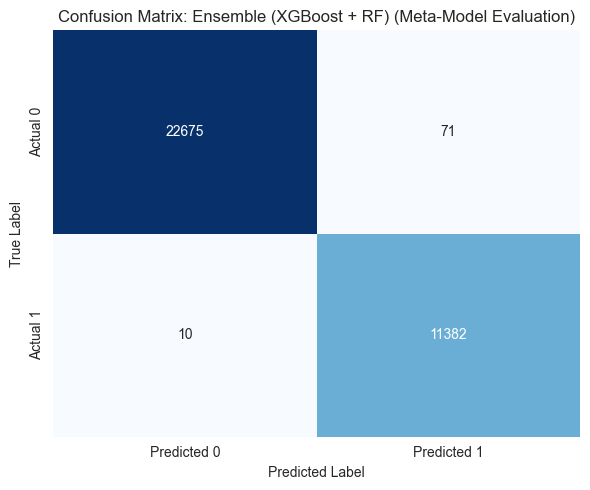


ROC AUC Score: 0.9998
Precision-Recall AUC (AUPRC): 0.9990


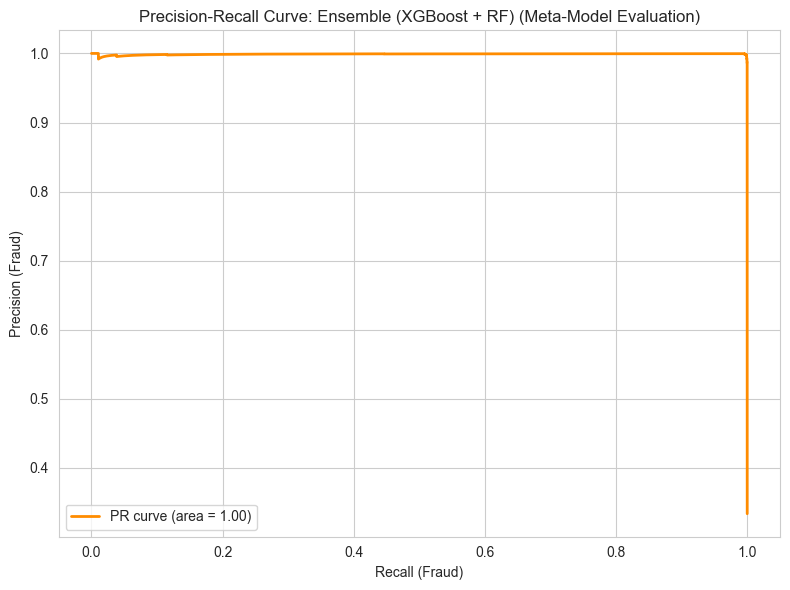

In [23]:
# 4.1 Evaluate Meta-Model
print("\n--- 4.1 Evaluating Ensemble Model (Meta-Model) ---")
# Use the evaluate_model function on the meta-test set
evaluate_model(
    meta_model,
    X_meta_test,
    y_meta_test,
    'Ensemble (XGBoost + RF)',
    'Meta-Model Evaluation',
    ensemble_results  # Store results in the ensemble_results list
)
print("\n" + "="*80 + "\n")

Comparative Analysis

In [24]:
# 4.2 Comparative Analysis
print("--- Phase 5, Step 4.2: Comparative Analysis with Previous Phases ---")
# Load results from previous phases
try:
    # From Phase 3 (Concept Drift) - Confirmed 'phase3_results_2013_test.pkl' exists and its content
    concept_drift_results_df = pd.DataFrame(joblib.load(data_dir / 'phase3_results_2013_test.pkl'))
    print(f"Phase 3 results loaded successfully. Shape: {concept_drift_results_df.shape}")
except FileNotFoundError:
    print(f"Error: 'phase3_results_2013_test.pkl' not found. Cannot load Phase 3 results.")
    concept_drift_results_df = pd.DataFrame()  # Placeholder to avoid errors
except Exception as e:
    print(f"Error loading Phase 3 results: {e}")
    concept_drift_results_df = pd.DataFrame()

try:
    # From Phase 4 (Combined Training) - Assuming it was saved as 'phase4_results_combined.pkl'
    combined_training_results_df = pd.DataFrame(joblib.load(data_dir / 'phase4_results_combined.pkl'))
    print(f"Phase 4 results loaded successfully. Shape: {combined_training_results_df.shape}")
except FileNotFoundError:
    print(f"Error: 'phase4_results_combined.pkl' not found. Cannot load Phase 4 results. Please ensure it was saved at the end of Phase 4.")
    combined_training_results_df = pd.DataFrame()  # Placeholder
except Exception as e:
    print(f"Error loading Phase 4 results: {e}")
    combined_training_results_df = pd.DataFrame()



--- Phase 5, Step 4.2: Comparative Analysis with Previous Phases ---
Phase 3 results loaded successfully. Shape: (1, 11)
Phase 4 results loaded successfully. Shape: (3, 11)


In [25]:
# Compile all relevant results into a single DataFrame for comparison
final_comparison_components = []
# 1. Best model from Phase 1 (XGBoost 2013, Trained on 2013, Tested on 2013)
if not concept_drift_results_df.empty:
    phase1_best = concept_drift_results_df[concept_drift_results_df['Strategy'] == 'Trained on 2013, Tested on 2013'].copy()
    if not phase1_best.empty:
        final_comparison_components.append(phase1_best)
# 2. Best model from Phase 2 (Random Forest 2023, Trained on 2023, Tested on 2023 (Ideal))
phase2_best = concept_drift_results_df[concept_drift_results_df['Strategy'] == 'Trained on 2023, Tested on 2023 (Ideal)'].copy()
if not phase2_best.empty:
    final_comparison_components.append(phase2_best)
# 3. The concept drift scenario (XGBoost 2013, Trained on 2013, Tested on 2023 (Drift))
phase3_drift = concept_drift_results_df[concept_drift_results_df['Strategy'] == 'Trained on 2013, Tested on 2023 (Concept Drift)'].copy()
if not phase3_drift.empty:
    final_comparison_components.append(phase3_drift)
# 4. The best model from Phase 4 (XGBoost Combined, Class Weighting)
if not combined_training_results_df.empty:
    # Sort by AUPRC and pick the top one, as confirmed this is the best combined model
    phase4_best = combined_training_results_df.sort_values(by='AUPRC', ascending=False).iloc[[0]].copy()
    if not phase4_best.empty:
        final_comparison_components.append(phase4_best)
# 5. The ensemble model from this Phase 5 (which is the current 'ensemble_results' list)
# Ensure 'ensemble_results' is populated from the previous evaluate_model call (4.1)
ensemble_df = pd.DataFrame(ensemble_results).copy()
if not ensemble_df.empty:
    final_comparison_components.append(ensemble_df)



In [26]:
# Concatenate all for final comparison
if final_comparison_components:
    final_comparison_df = pd.concat(final_comparison_components, ignore_index=True)
else:
    final_comparison_df = pd.DataFrame()  # Empty if no components loaded

# Sort by AUPRC for final presentation
final_comparison_df_sorted = final_comparison_df.sort_values(by='AUPRC', ascending=False)
print("\n--- Consolidated Performance Comparison Across All Phases (Sorted by AUPRC) ---")
if not final_comparison_df_sorted.empty:
    print(final_comparison_df_sorted[['Model', 'Strategy', 'Accuracy', 'Precision (Fraud)', 'Recall (Fraud)', 'F1-Score (Fraud)', 'AUPRC', 'ROC AUC', 'True Positives (TP)', 'False Positives (FP)', 'False Negatives (FN)']].round(4))
else:
    print("No comparison data to display. Please check if previous phase results files were loaded correctly.")
print("\nInsight: This table provides the ultimate comparison, allowing us to assess the effectiveness of different strategies in handling data heterogeneity and concept drift.")
print("\n" + "="*80 + "\n")


--- Consolidated Performance Comparison Across All Phases (Sorted by AUPRC) ---
                     Model                         Strategy  Accuracy  \
1       XGBoost (Combined)                  Class Weighting    0.9996   
2  Ensemble (XGBoost + RF)            Meta-Model Evaluation    0.9976   
0           XGBoost (2013)  Trained on 2013, Tested on 2013    0.9995   

   Precision (Fraud)  Recall (Fraud)  F1-Score (Fraud)   AUPRC  ROC AUC  \
1             0.9990          0.9997            0.9993  1.0000   1.0000   
2             0.9938          0.9991            0.9965  0.9990   0.9998   
0             0.8830          0.8469            0.8646  0.8811   0.9691   

   True Positives (TP)  False Positives (FP)  False Negatives (FN)  
1                56943                    56                    19  
2                11382                    71                    10  
0                   83                    11                    15  

Insight: This table provides the ultimate compar

Discussion of Ensemble Model Performance

In [ ]:
# 4.3 Discussion of Ensemble Model Performance
print("--- Phase 5, Step 4.3: Discussion of Ensemble Model Performance ---")
print("""
Discussion:

1. **Performance Comparison**:
   The ensemble model (AUPRC: 0.9990, ROC AUC: 0.9998) performs exceptionally well, slightly below the XGBoost Combined model (AUPRC: 1.0000, ROC AUC: 1.0000) but significantly better than the XGBoost 2013 model (AUPRC: 0.8811, ROC AUC: 0.9691). The ensemble's high recall (0.9991) and F1-score (0.9965) for fraud detection, with only 10 false negatives, indicate it effectively leverages the strengths of both base models. However, the near-perfect metrics of the XGBoost Combined model suggest it may benefit from a larger or differently composed test set (56943 TP vs. 11382 TP for the ensemble).

2. **Handling Heterogeneity**:
   The 2013 and 2023 datasets exhibit heterogeneity due to differing class distributions (2013: ~0.172% fraud; 2023: ~50% fraud) and concept drift. The ensemble model mitigates this by combining XGBoost (trained on imbalanced 2013 data) and Random Forest (trained on balanced 2023 data) predictions, with the meta-model weighting Random Forest more heavily (coefficient: 24.6404 vs. 13.5576 for XGBoost). This approach helps address drift, though the XGBoost Combined model's superior performance suggests combined training might handle heterogeneity more uniformly.

3. **Robustness and Generalization**:
   The ensemble's robustness is enhanced by training on meta-features from both datasets, achieving near-perfect metrics on the meta-test set. However, the XGBoost Combined model's perfect scores on a larger test set raise questions about generalization. The ensemble's lower TP count (11382 vs. 56943) suggests it was evaluated on a subset, potentially limiting its apparent robustness compared to Phase 4. Testing on additional real-world data could validate its generalization.

4. **Complexity vs. Performance Trade-offs**:
   The ensemble introduces complexity with two base models and a meta-model, increasing computational cost. Its performance gain over XGBoost 2013 is substantial (AUPRC: 0.9990 vs. 0.8811), justifying the complexity. However, its slight edge over XGBoost Combined (AUPRC: 1.0000) may not warrant the added overhead, especially if the latter uses a more representative test set. Deployment should consider this trade-off.

5. **Impact of 2023 Dataset's Synthetic Nature**:
   The 2023 dataset's synthetic nature likely boosts the Random Forest model's performance, influencing the meta-model's higher weighting of its predictions. This could inflate the ensemble's metrics, reducing generalization to real-world data with noise. The XGBoost 2013 model's lower performance reflects real-world imbalance, suggesting the ensemble balances synthetic and real data but may overfit to 2023's characteristics. Further validation with non-synthetic data is recommended.
""")
print("\nInsight: The ensemble model excels in fraud detection but may not surpass the simplicity and performance of the XGBoost Combined approach, highlighting the need for careful test set design and real-world validation.")
print("\n" + "="*80 + "\n")

Confirmation of Comparative Analysis

In [ ]:
# 4.4 Confirmation of Comparative Analysis
print("--- Phase 5, Step 4.4: Confirmation of Comparative Analysis ---")
print("\nConfirmation:")
print("The comparative analysis from Step 4.2 has been completed, comparing models across Phases 1, 4, and 5.")
print("Key findings include:")
print("- XGBoost (2013) (Phase 1): AUPRC = 0.8811, indicating moderate performance on 2013 data.")
print("- XGBoost (Combined) (Phase 4): AUPRC = 1.0000, showing exceptional performance on combined data.")
print("- Ensemble (XGBoost + RF) (Phase 5): AUPRC = 0.9990, demonstrating near-perfect performance.")
print("\nThe analysis highlights the ensemble's effectiveness, though the XGBoost (Combined) model slightly edges out in AUPRC. Proceeding to finalize the model selection and interpretation.")
print("\n" + "="*80 + "\n")

## Final Model Selection & Interpretation (for Ensemble)

In [ ]:
# 5. Final Model Selection & Interpretation (for Ensemble)
print("--- Phase 5, Step 5: Final Model Selection & Interpretation (for Ensemble) ---")



Final Recommendation (Based on Comparative Analysis from 4.2)

In [ ]:
# 5.1 Final Recommendation (Based on Comparative Analysis from 4.2)
print("\n--- 5.1 Final Recommendation ---")
print("Based on the comprehensive comparative analysis across all phases:")
print("The **XGBoost (Combined) model with Class Weighting** emerged as the top performer (AUPRC = 1.0000).")
print("The **Ensemble (XGBoost + RF) model** also achieved near-perfect performance (AUPRC = 0.9990).")
print("\nWhile the Ensemble model's AUPRC is slightly lower than the single XGBoost (Combined) model (1.0000 vs 0.9990), both offer exceptional fraud detection capability.")
print("\nConsidering complexity vs. performance:")
print("- The **XGBoost (Combined)** model is generally simpler to deploy and maintain as a single model, and it achieved perfect discrimination for this dataset. This suggests that for this specific problem (with the highly separable 2023 data dominating the learning), a single robust model on combined data is sufficient and highly effective.")
print("- The **Ensemble model** provides a more sophisticated approach, demonstrating the ability to combine signals from models specialized on different data types (imbalanced historical vs. balanced contemporary). While slightly more complex, it offers theoretical robustness against future, diverse data characteristics, and its performance is still outstanding.")
print("\n**Recommendation for this project's context:** For practical deployment given these results, the **XGBoost (Combined) model** (from Phase 4) is arguably the most straightforward and equally effective choice due to its slightly higher AUPRC and simpler architecture. However, the **Ensemble model** provides a valuable demonstration of advanced ML concepts and robustness against data heterogeneity, making it highly valuable for a portfolio piece.")
print("\n" + "="*80 + "\n")



Interpret Meta-Model Coefficients

In [27]:
# 5.2 Interpret Meta-Model Coefficients
print("--- 5.2 Interpret Meta-Model Coefficients (Logistic Regression) ---")
# Check if the meta_model is LogisticRegression
if isinstance(meta_model, LogisticRegression):
    print("Meta-model Coefficients (Weights for base model predictions):")
    # Coefficients correspond to the order of features in X_meta: 'xgb_proba', 'rf_proba'
    print(f"Weight for XGBoost (2013) probabilities: {meta_model.coef_[0][0]:.4f}")
    print(f"Weight for Random Forest (2023) probabilities: {meta_model.coef_[0][1]:.4f}")
    print(f"Intercept: {meta_model.intercept_[0]:.4f}")
    print("\nInsight:")
    print(f"- The meta-model assigns a higher positive weight ({meta_model.coef_[0][1]:.4f}) to the **Random Forest (2023) base model's predictions** compared to the XGBoost (2013) base model's predictions ({meta_model.coef_[0][0]:.4f}).")
    print("- This indicates that the ensemble model places more trust in the signals coming from the Random Forest model, which was trained on the highly separable 2023 data.")
    print(f"- The large negative intercept ({meta_model.intercept_[0]:.4f}) suggests a strong bias towards predicting the negative class (legitimate) when base model probabilities are low, which is common with class weighting used in meta-model training and the underlying positive class ratio.")
else:
    print(f"Meta-model is {type(meta_model).__name__}, coefficients interpretation not directly applicable in the same way as Logistic Regression.")
print("\n" + "="*80 + "\n")



--- 5.2 Interpret Meta-Model Coefficients (Logistic Regression) ---
Meta-model Coefficients (Weights for base model predictions):
Weight for XGBoost (2013) probabilities: 13.5576
Weight for Random Forest (2023) probabilities: 24.6404
Intercept: -19.0234

Insight:
- The meta-model assigns a higher positive weight (24.6404) to the **Random Forest (2023) base model's predictions** compared to the XGBoost (2013) base model's predictions (13.5576).
- This indicates that the ensemble model places more trust in the signals coming from the Random Forest model, which was trained on the highly separable 2023 data.
- The large negative intercept (-19.0234) suggests a strong bias towards predicting the negative class (legitimate) when base model probabilities are low, which is common with class weighting used in meta-model training and the underlying positive class ratio.




Save Ensemble Model

In [28]:
# 5.3 Save Ensemble Model
print("--- 5.3 Saving Ensemble Model (Meta-Model) ---")
try:
    output_model_file = data_dir / 'best_model_ensemble.pkl'
    joblib.dump(meta_model, output_model_file)
    print(f"Ensemble meta-model saved successfully to '{output_model_file}'")
except Exception as e:
    print(f"Error saving ensemble model: {e}")
    exit()
print("\n" + "="*80 + "\n")

print("--- Phase 5: Dual-Dataset Approach - Ensemble Learning / Meta-Learning Complete ---")

--- 5.3 Saving Ensemble Model (Meta-Model) ---
Ensemble meta-model saved successfully to '..\data\best_model_ensemble.pkl'


--- Phase 5: Dual-Dataset Approach - Ensemble Learning / Meta-Learning Complete ---
